## Model Training

### Feature Extraction from Images

Importing the necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = EfficientNet_B7_Weights.DEFAULT
model = efficientnet_b7(weights=weights)

# remove classifier → features only
feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
feature_extractor.eval()

# correct preprocessing
transform = weights.transforms()

In this section, we load a pretrained EfficientNet-B7 model and convert it into a 
feature extractor instead of using it as a classifier. The code first checks whether 
a GPU is available and moves the model to the appropriate device for faster 
computation. We then load ImageNet-trained weights, which allow the network to 
leverage rich visual features learned from large-scale data. 

By removing the final classification layer and keeping only the convolutional body, 
the network outputs high-level image representations instead of class labels. These 
feature vectors can later be combined with tabular housing features and passed into 
our regression model. Finally, the appropriate preprocessing transforms from the 
weights object are used to ensure that all images are normalized and resized in a 
way that matches how EfficientNet was originally trained.

In [ ]:
def extract_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = feature_extractor(img)

    return feat.view(-1).cpu().numpy()

This function loads an image, preprocesses it, and passes it through the 
EfficientNet feature extractor to obtain a compact numerical representation. 
Each image is first converted to RGB and transformed using the same normalization 
pipeline as EfficientNet. A batch dimension is added, and the tensor is moved 
to the correct device (CPU or GPU).  

Gradients are disabled since the network is used only for inference, not 
training. The model outputs a high-level feature map, which is flattened into 
a one-dimensional vector and converted to a NumPy array. This feature vector 
captures important visual patterns from the image and is later combined with 
tabular inputs for price prediction.

In [ ]:
image_dir = "train_img"
features = []
ids = []
bad_ids = []          # <── store invalid ones here

for filename in tqdm(os.listdir(image_dir)):
    if filename.endswith(".png"):
        img_id = filename.replace(".png","")
        path = os.path.join(image_dir, filename)

        try:
            vec = extract_features(path)
            features.append(vec)
            ids.append(img_id)

        except Exception as e:
            print(f"[SKIP] {filename} — {e}")
            bad_ids.append(img_id)    # <── remember this id
            continue

train_img_features = pd.DataFrame(features)
train_img_features["id"] = ids

train_img_features.to_csv("train_image_features.csv", index=False)
print("Saved train_image_features.csv")

pd.DataFrame({"id": bad_ids}).to_csv("bad_train_image_ids.csv", index=False)
print("Saved bad ids → bad_train_image_ids.csv")

This loop processes every image in the training directory and builds a feature 
matrix. For each image file, we extract its numeric feature vector using the 
pretrained EfficientNet feature extractor. These vectors are collected and 
stored along with their corresponding property IDs.

If any image cannot be processed (for example, due to corruption or download 
issues), that ID is recorded separately and skipped so the pipeline does not 
stop. The list of failed image IDs is saved to `bad_train_image_ids.csv`, which 
can later be used to re-download or inspect problematic images.

The final feature matrix is stored in `train_image_features.csv`, where each row 
represents one property and contains the extracted visual features followed by 
its ID. These features are later merged with the tabular dataset and used during 
model training.

In [ ]:
image_dir = "test_img"

features = []
ids = []
bad_ids = []      # <── store invalid test image ids

for filename in tqdm(os.listdir(image_dir)):
    if filename.endswith(".png"):
        img_id = filename.replace(".png","")
        path = os.path.join(image_dir, filename)

        try:
            vec = extract_features(path)
            features.append(vec)
            ids.append(img_id)

        except Exception as e:
            print(f"[SKIP] {filename} — {e}")
            bad_ids.append(img_id)
            continue

test_img_features = pd.DataFrame(features)
test_img_features["id"] = ids

test_img_features.to_csv("test_image_features.csv", index=False)
print("Saved test_image_features.csv")

pd.DataFrame({"id": bad_ids}).to_csv("bad_test_image_ids.csv", index=False)
print("Saved bad test ids → bad_test_image_ids.csv")

This block performs the same feature extraction process on the test images. 
Each image is passed through the EfficientNet feature extractor, and the 
resulting feature vectors are stored together with their property IDs. Images 
that fail to load are skipped and their IDs are recorded in 
`bad_test_image_ids.csv` for later review.  

The final output, `test_image_features.csv`, contains feature vectors for all 
valid test images and will be merged with the test dataset during prediction.

In [51]:
train_fe = pd.read_csv("train_image_features.csv")
test_fe = pd.read_csv("test_image_features.csv")

In [52]:
train_fe

,0,1,2,3,4,5,6,7,8,9,...,2551,2552,2553,2554,2555,2556,2557,2558,2559,id
0,0.063956,0.124507,-0.047171,-0.166595,-0.032263,-0.018367,0.014357,0.036748,-0.024116,0.015283,...,0.221741,-0.151224,-0.033085,0.149933,0.185219,-0.032791,0.174587,-0.044872,-0.118468,7016310030
1,0.217264,0.195637,0.228715,-0.185213,-0.056003,-0.091588,-0.103132,0.229704,0.004099,0.257945,...,0.307495,-0.119471,-0.017757,0.170227,0.025216,-0.078994,0.094113,-0.103563,0.125984,3422059085
2,-0.007968,0.151345,0.123488,-0.206935,0.110490,-0.148574,-0.065530,0.002444,0.125665,0.178986,...,0.345739,-0.190752,-0.126086,0.104489,-0.013810,-0.035011,0.433745,0.002229,0.186612,7504010480
3,0.266572,0.228906,0.065364,-0.201281,-0.052620,-0.100968,-0.010699,-0.014176,0.122664,0.160546,...,0.349280,-0.230943,-0.072662,0.075228,0.052496,-0.092174,0.305098,-0.091823,-0.066107,8121100325
4,0.045610,0.246433,0.159013,-0.160705,-0.100217,-0.017630,-0.020712,0.016349,0.016142,0.110430,...,0.267268,-0.198746,-0.100481,-0.023439,0.060194,-0.177499,0.415467,-0.025823,0.098921,9352900222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16105,0.068752,-0.019677,0.173899,-0.201290,0.006230,-0.027755,0.082422,-0.014691,0.033414,0.044023,...,0.470132,-0.192588,0.068145,0.202577,0.092331,-0.095767,0.418551,-0.200379,0.000333,7502800030
16106,0.106088,0.148664,0.130689,-0.176634,-0.003706,-0.154404,-0.033967,0.254465,-0.074123,0.254758,...,0.256474,-0.175823,-0.078741,0.102591,0.066450,-0.101894,0.132614,-0.066866,-0.090587,7979900215
16107,0.234572,0.391568,0.115717,-0.090186,-0.044028,0.096868,-0.010624,0.038189,0.131626,0.161084,...,0.492747,-0.132868,-0.042227,0.076259,0.128076,-0.107533,0.211712,-0.082198,0.037588,4006000509
16108,-0.036055,0.003261,0.298199,-0.208225,0.344284,-0.159410,0.019761,0.036882,0.192392,0.127480,...,0.402430,-0.200260,-0.142718,0.208868,-0.028846,-0.026820,0.164412,-0.157655,-0.077401,6902000100


In [53]:
test_fe

,0,1,2,3,4,5,6,7,8,9,...,2551,2552,2553,2554,2555,2556,2557,2558,2559,id
0,0.010346,0.005331,0.367353,-0.140115,-0.199248,-0.103202,-0.202781,-0.129967,-0.135987,-0.080807,...,0.313688,-0.188709,-0.215869,-0.073544,-0.016362,-0.183137,0.388996,-0.139578,0.351989,3387900390
1,0.160740,0.130965,0.056553,-0.203302,-0.073600,-0.045328,-0.027404,-0.027186,0.054868,0.089104,...,0.426261,-0.188195,-0.114152,0.181488,0.057489,-0.197548,0.358367,-0.076214,0.003868,6163900981
2,0.035918,0.060613,0.247986,-0.207725,-0.074980,0.001754,-0.118750,0.031558,-0.015354,-0.038582,...,0.464703,-0.131448,-0.178190,0.043676,0.045093,-0.099996,0.403193,-0.039105,0.241765,3972900215
3,0.081681,0.012733,0.140057,-0.151011,0.244626,-0.054242,-0.123129,-0.093152,0.054039,0.191476,...,0.658847,-0.217022,-0.169239,0.228128,0.041625,-0.091167,0.311972,0.006018,0.236536,1726069084
4,0.378296,0.039196,0.144753,-0.197420,0.108042,-0.129783,-0.103169,-0.039115,-0.043385,-0.060987,...,0.180412,-0.207891,-0.121639,0.163585,-0.027194,-0.122697,0.088786,-0.063883,-0.098450,1224059053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,0.312991,0.069284,0.147843,-0.142383,-0.079017,0.074935,-0.019665,0.029527,0.025900,0.015972,...,0.415967,-0.153722,-0.032087,0.313835,0.099311,-0.126388,0.498816,-0.101456,0.078101,726059483
5392,0.350504,0.158158,0.143767,-0.190117,0.099029,0.054484,0.068104,-0.091721,0.291330,-0.015235,...,0.346678,-0.224429,-0.024516,0.192757,0.074779,-0.127309,0.434204,0.037949,-0.033212,6852700476
5393,0.056321,0.142334,0.223945,-0.162048,-0.190791,-0.136587,-0.154122,-0.162025,0.139438,0.018197,...,0.344687,-0.159956,-0.084714,-0.081977,-0.029260,-0.066173,0.201111,-0.177791,0.397565,7212650990
5394,0.086878,0.121554,0.202058,-0.236055,-0.199980,-0.021963,-0.118601,-0.051661,-0.085597,0.003786,...,0.168346,-0.167379,-0.174540,-0.029193,-0.013455,-0.142111,0.545662,-0.186930,0.134922,3336001946


### PCA for Extracted Features

In [ ]:
# select only the image feature columns (they are named f0, f1, f2... or numeric)
image_cols = [c for c in train_fe.columns if c.startswith("f") or c.isdigit()]

Importing Necessary Libraries

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

In [ ]:
# fit PCA ONLY on image columns from training set
pca_temp = PCA().fit(train_fe[image_cols])

# cumulative explained variance
cum_var = np.cumsum(pca_temp.explained_variance_ratio_)

# find how many components reach 95%
n_components_95 = np.argmax(cum_var >= 0.95) + 1

print("Components needed for 95% variance:", n_components_95)

Components needed for 95% variance: 325


Here, PCA is fitted only on the image feature columns to understand how many 
principal components are required to retain most of the information. After 
fitting PCA, we compute the cumulative explained variance and identify the 
smallest number of components whose cumulative variance reaches at least 95%.  

This tells us how much we can safely compress the high-dimensional image 
features without losing significant information. In this case, 325 components 
capture roughly 95% of the variance.

In [57]:
from sklearn.decomposition import PCA
import numpy as np

pca_full = PCA().fit(train_fe[image_cols])

cum_var = np.cumsum(pca_full.explained_variance_ratio_)


In this step, PCA is fitted on the full set of extracted image features.  
We do not limit the number of components yet — instead, we allow PCA to compute 
all possible principal components. After fitting, we calculate the cumulative 
explained variance, which tells us how much total variance is captured as we 
progressively include more components.  

This cumulative curve is later used to decide an optimal number of PCA 
components (for example, the point where 90–95% of the variance is retained).


#### Visualizing PCA Explained Variance


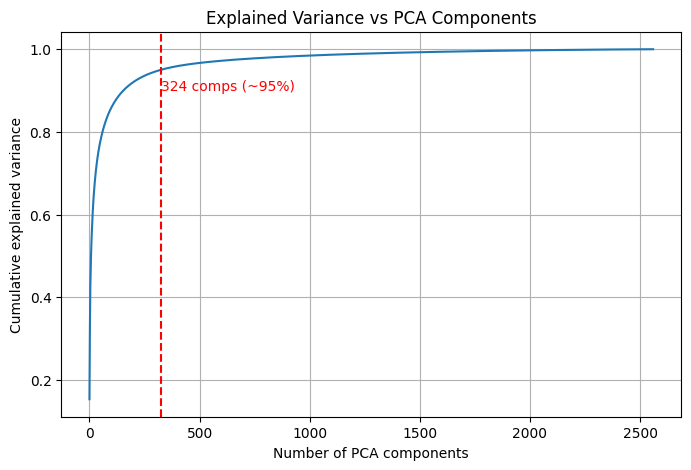

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(cum_var)
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance vs PCA Components")
plt.grid(True)

# optional: mark 95%
idx_95 = np.argmax(cum_var >= 0.95)
plt.axvline(idx_95, color="red", linestyle="--")
plt.text(idx_95, 0.90, f"{idx_95} comps (~95%)", color="red")

plt.show()

The plot above shows how much total variance is captured as we increase the number of PCA components. Each point represents the cumulative variance explained by the first *k* components.

We also draw a vertical dashed red line at the point where cumulative variance first exceeds ~95%. This helps us visually choose a good dimensionality: we keep enough components to retain most of the information, while discarding redundant or noisy ones. In our case, around **~324 components** capture roughly **95% of the variance**, which dramatically reduces dimensionality compared to the original image feature space.

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=325, random_state=42)

# fit only on training images
pca.fit(train_fe[image_cols])

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",325
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SV


Here we create a PCA model and set the number of components to **325**, which we previously determined captures about **95% of the variance**.  

In [60]:
train_pca = pca.transform(train_fe[image_cols])
test_pca  = pca.transform(test_fe[image_cols])

In [61]:
pca_cols = [f"pca_{i}" for i in range(325)]

In [62]:
train_pca = pd.DataFrame(train_pca, columns=pca_cols)
train_pca["id"] = train_fe["id"].values

In [63]:
test_pca = pd.DataFrame(test_pca, columns=pca_cols)
test_pca["id"] = test_fe["id"].values


After fitting PCA, we project both the **train** and **test** image feature matrices into the
reduced 325-dimensional space

In [64]:
train_fe = train_pca
test_fe  = test_pca

In [65]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [66]:
train_merged = train.merge(train_fe, on="id", how="left")
test_merged  = test.merge(test_fe,  on="id", how="left")

Here we join the original tabular datasets with the extracted image features using the
common `id` column

In [67]:
train_merged

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,pca_315,pca_316,pca_317,pca_318,pca_319,pca_320,pca_321,pca_322,pca_323,pca_324
0,9117000170,2015-05-05,268643,4,2.25,1810,9240,2.0,0,0,...,-0.048746,0.051529,-0.000131,-0.124930,-0.012265,-0.075218,0.036016,0.030052,-0.002671,-0.029014
1,6700390210,2014-07-08,245000,3,2.50,1600,2788,2.0,0,0,...,0.022569,0.026762,0.112892,-0.074373,0.074147,-0.111367,0.076954,0.048233,-0.054385,0.101486
2,7212660540,2015-01-15,200000,4,2.50,1720,8638,2.0,0,0,...,-0.011660,-0.019910,-0.051581,0.077840,-0.014835,-0.001093,-0.076307,-0.057015,-0.017829,0.008147
3,8562780200,2015-04-27,352499,2,2.25,1240,705,2.0,0,0,...,-0.072878,0.029876,-0.101611,0.085941,0.011039,0.020771,-0.113385,-0.066271,-0.053677,-0.151560
4,7760400350,2014-12-05,232000,3,2.00,1280,13356,1.0,0,0,...,-0.066507,-0.031288,0.018708,0.094909,-0.026950,0.155099,-0.002118,0.109578,-0.021024,-0.009229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,5272200045,2014-11-13,378000,3,1.50,1000,6914,1.0,0,0,...,-0.062578,0.020797,0.021853,-0.077430,0.207375,0.000823,0.031269,0.065782,-0.170718,-0.034979
16205,9578500790,2014-11-11,399950,3,2.50,3087,5002,2.0,0,0,...,0.099137,0.090100,0.036881,0.029780,0.093192,0.065434,0.046121,-0.009601,-0.120657,0.063995
16206,7202350480,2014-09-30,575000,3,2.50,2120,4780,2.0,0,0,...,0.121235,-0.121324,0.120868,0.063993,0.158742,0.063555,-0.079238,0.008024,-0.098916,-0.078012
16207,1723049033,2014-06-20,245000,1,0.75,380,15000,1.0,0,0,...,0.136855,-0.127851,-0.014497,0.042605,-0.032304,0.013677,0.091176,-0.030720,-0.105340,0.102709


In [68]:
train_merged["date"] = pd.to_datetime(train_merged["date"])

train_merged["year"] = train_merged["date"].dt.year
train_merged["month"] = train_merged["date"].dt.month
train_merged["day"] = train_merged["date"].dt.day

train_merged = train_merged.drop(columns=["date"])

In [69]:
test_merged["date"] = pd.to_datetime(test_merged["date"])

test_merged["year"] = test_merged["date"].dt.year
test_merged["month"] = test_merged["date"].dt.month
test_merged["day"] = test_merged["date"].dt.day

test_merged = test_merged.drop(columns=["date"])

The original dataset stores the sale date as a single string field.  
Instead of using the raw timestamp, we convert it into meaningful components.

### Modelling

In [70]:
target = "price"


X = train_merged.drop(columns=[target])
y = train_merged[target]

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

Splitting the dataset for validation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("xgb", XGBRegressor(
        tree_method="hist",
        random_state=42,
        n_estimators=1500,     # large, rely on early stopping
        eval_metric="rmse"
    ))
])

param_dist = {
    "xgb__learning_rate": [0.03, 0.05, 0.1],
    "xgb__max_depth": [4, 6],
    "xgb__min_child_weight": [1, 5],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__reg_alpha": [0, 0.1],
    "xgb__reg_lambda": [1, 2],
    "xgb__gamma": [0, 0.1],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)


This section defines the end-to-end modeling pipeline and performs automated hyperparameter tuning using `RandomizedSearchCV`. We first construct a Scikit-Learn `Pipeline` consisting of two main steps: a `StandardScaler` and an `XGBRegressor`. The scaler standardizes all numeric features so they are on comparable magnitude, which is particularly important because our dataset combines structured variables and PCA-compressed image features that exist on very different scales. XGBoost (XGBRegressor) is chosen as the core regression model because it performs exceptionally well on structured tabular data, models complex non-linear relationships, handles missing values gracefully, and is robust to overfitting when appropriately regularized. We configure XGBoost to use the histogram tree method for faster training, a relatively large number of trees, RMSE as the evaluation metric, and a fixed random seed to ensure reproducibility.

Instead of manually tuning hyperparameters, we define a controlled search space covering the most influential parameters such as learning rate, tree depth, regularization penalties, and sampling ratios. These parameters determine how complex, flexible, and regularized the model becomes. To efficiently explore this space, we use `RandomizedSearchCV`, which randomly samples 40 parameter combinations and evaluates each using 3-fold cross-validation. This strikes a balance between computational cost and tuning quality. RMSE is used as the scoring metric to align tuning with the final evaluation objective. The search also runs in parallel across all available CPU cores for speed and uses a fixed random seed so experiments can be reproduced.

In [74]:
import xgboost as xgb

search.fit(X_train, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lambda=1, xgb__subsample=0.7; total time= 3.2min
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lambda=1, xgb__subsample=0.7; total time= 3.3min
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__reg_alpha=0, xgb__reg_lambda=2, xgb__subsample=0.9; total time= 3.3min
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__reg_alpha=0, xgb__reg_lambda=2, xgb__subsample=0.9; total time= 3.4min
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__reg_alpha=0, xgb__reg_lambda

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'xgb__colsample_bytree': [0.7, 0.9], 'xgb__gamma': [0, 0.1], 'xgb__learning_rate': [0.03, 0.05, ...], 'xgb__max_depth': [4, 6], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategie

In [75]:
print("Best RMSE (CV):", -search.best_score_)
print("Best Params:", search.best_params_)


Best RMSE (CV): 126184.10416666667
Best Params: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0, 'xgb__min_child_weight': 1, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.7}


The tuning process achieved a **best cross-validated RMSE of ~126,184**, indicating the typical average difference between predicted and actual house prices on unseen folds. Because this value is based on cross-validation, it provides a trustworthy estimate of real-world performance.

The selected hyperparameters describe a model that is intentionally conservative and regularized. A **low learning rate (0.03)** and **shallow trees (max depth = 4)** help prevent overfitting, while **subsample = 0.7** and **colsample_bytree = 0.7** add randomness to make the model more robust. Regularization is mainly handled through **L2 (lambda = 1)**, while L1 regularization was not needed. Altogether, this configuration balances accuracy and stability rather than pushing for an overly complex model.


In [76]:
model = search.best_estimator_

In [78]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('xgb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",False
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None


In [79]:
from sklearn.metrics import mean_squared_error
import numpy as np

val_preds = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("Validation RMSE:", rmse)

Validation RMSE: 118328.7223289426


In [81]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val,val_preds)
print("R²:", r2)

R²: 0.8884226679801941


To evaluate the model’s performance on the validation data, we computed two metrics — **Root Mean Squared Error (RMSE)** and **R² (coefficient of determination)**.

- **RMSE** tells us, on average, how far the predicted prices are from the actual prices, measured in the same units as the target variable.  
  In our case, the RMSE value of **118,328** indicates that predictions deviate from true prices by roughly this amount on average. A lower RMSE means better performance.

- **R²** measures how much of the variation in house prices is explained by the model.  
  The value of **0.888** shows that the model explains **about 88.8% of the total variance** in the target, which indicates strong predictive capability.

Overall, these results suggest that the model fits the data well and generalizes effectively, while still leaving some scope for further improvement.


In [82]:
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

model.fit(X_train, y_train_log)
val_preds_log = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, np.expm1(val_preds_log)))

In [83]:
print(rmse)

115537.87784099205


In [84]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, np.expm1(val_preds_log))
print("R²:", r2)

R²: 0.8936238288879395


Here, the target variable (house price) is first transformed using **log1p** before training the model. This helps stabilize variance, reduce the influence of extreme outliers, and often leads to better learning behavior for regression models.

After training on the log-transformed prices, predictions are produced in the **log scale**, so we convert them back using **expm1** before evaluation.

- The resulting **RMSE = 115,538**, meaning the predictions differ from true prices by about ₹115k on average (after converting back from log scale).  
- The **R² = 0.8936**, showing that the model explains roughly **89% of the variance** in housing prices.

Compared to training directly on raw prices, using the log transformation slightly improves both RMSE and R², indicating more stable and accurate predictions, especially for high-value properties.

In [99]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# predictions (already in log space)
val_preds_log = model.predict(X_val)

# back-transform to price scale
val_preds = np.expm1(val_preds_log)

# build comparison table
results = pd.DataFrame({
    "id": X_val["id"].values,
    "true_price": y_val.values,
    "predicted_price": val_preds,
})

# absolute error
results["error"] = np.abs(results["true_price"] - results["predicted_price"])

# sort by lowest error (most accurate)
best_predictions = results.sort_values(by="error").head(20)

print(best_predictions)

              id  true_price  predicted_price       error
1121  2817100040      355000    355008.406250    8.406250
400   7852030310      440000    439966.562500   33.437500
2732  6145601890      415000    414961.562500   38.437500
1188  1402950190      321000    321103.406250  103.406250
511   2787320430      264000    263832.687500  167.312500
732   9477730080      377000    377171.843750  171.843750
2723   123039336      148000    148181.718750  181.718750
1804  9828702902      495000    494797.593750  202.406250
2542   937000330      246500    246285.875000  214.125000
2097  4166600610      335000    335224.593750  224.593750
293   5557700210      192500    192736.890625  236.890625
2342  8091670020      379000    378746.656250  253.343750
1697  9541600490      931088    931352.625000  264.625000
507   6306100080      234950    234651.046875  298.953125
1823  1545801410      276900    277200.843750  300.843750
2703  1355000220      243000    242653.296875  346.703125
1240  21933300

##### Identifying the Most Accurate Predictions

This block of code finds the validation samples where the model predicted prices **closest to the true values**.

1. First, the model produces predictions in **log space**. These are converted back to real price values using `expm1()` so they can be compared directly with true prices.
2. A results table is created containing:
   - the property **id**
   - the **true price**
   - the **predicted price**
3. An **absolute error** column is added

4. Finally, the rows are sorted by this error column, and the top 20 lowest-error predictions are displayed — meaning these are the houses the model predicted **almost perfectly**.

This helps inspect where the model performs best, verify correctness, and understand scenarios where the model is highly confident and accurate.

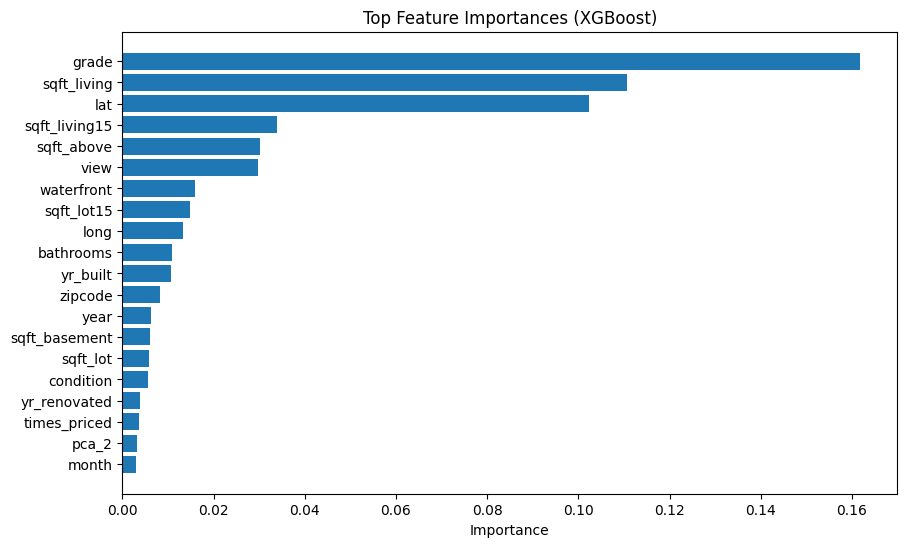

In [85]:
xgb_model = search.best_estimator_.named_steps["xgb"]

# if X_train is a pandas dataframe:
feature_names = X_train.columns  

importances = xgb_model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi["feature"][:20], fi["importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top Feature Importances (XGBoost)")
plt.show()

This plot shows which features contributed the most to the XGBoost model’s predictions.  
Features such as **grade, sqft_living, and location coordinates (lat/long)** have the highest importance, meaning the model relies on them heavily when estimating prices.  
Lower-ranked features still contribute, but removing them would likely have less impact on performance.  

Overall, this helps verify that the model is learning meaningful relationships (larger homes, better quality, and desirable locations generally predict higher prices).


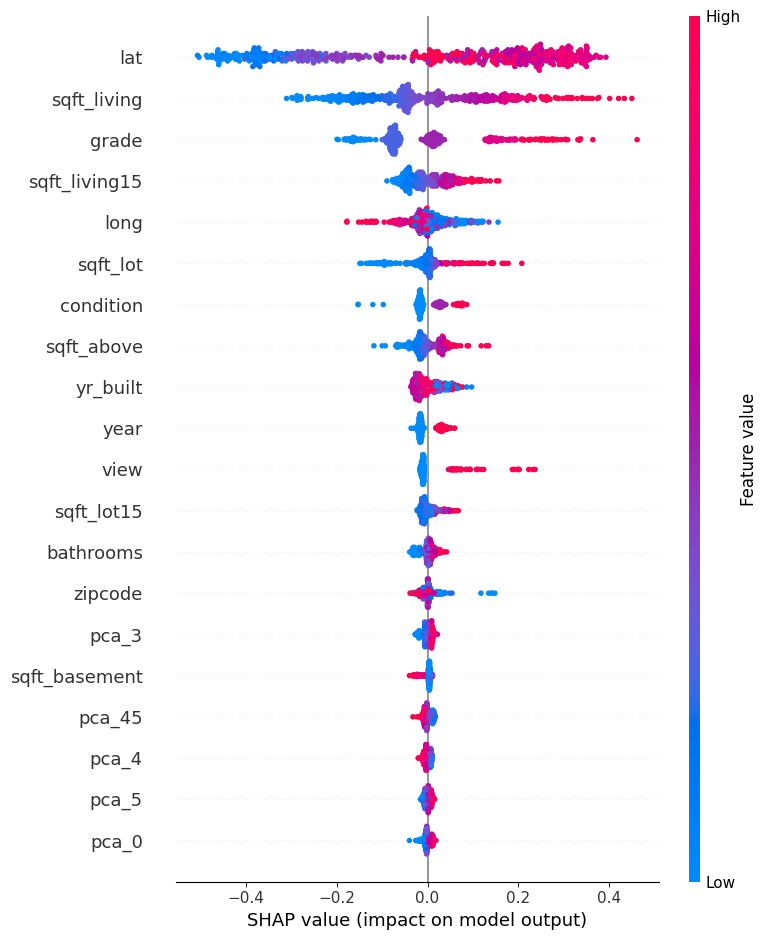

In [86]:
import shap

# 1) extract XGB model
xgb_model = search.best_estimator_.named_steps["xgb"]

# 2) transform X_val using the scaler
scaler = search.best_estimator_.named_steps["scaler"]
X_val_scaled = scaler.transform(X_val)

feature_names = X_val.columns   # original names

# 3) SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# 4) compute SHAP values (sample to speed up)
shap_values = explainer.shap_values(X_val_scaled[:500])

# 5) summary plot
shap.summary_plot(
    shap_values,
    X_val_scaled[:500],
    feature_names=feature_names
)


This SHAP summary plot explains **how each feature pushes the predicted price up or down**.  
Each dot represents a single house, and the color indicates whether the feature value is **low (blue)** or **high (red)**.

- Features like **latitude, living area (sqft_living), and grade** show strong influence — higher values generally push predictions higher.
- Some features have both positive and negative effects depending on context, showing non-linear relationships.
- PCA components appear, but their effect is indirect (capturing image-based patterns).

Overall, this visualization confirms that the model is learning intuitive behavior:  
**larger, higher-grade homes in desirable locations are predicted to cost more.**


In [87]:
shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values[1],
    feature_names=feature_names
)


This code initializes SHAP’s interactive visualization and generates a **force plot** for a single house.  
The plot shows **which features pushed the price up and which pushed it down**, relative to the model’s average prediction — helping interpret an individual prediction clearly.


In [88]:
val_ids = X_val["id"].values

In [91]:
X_test = test_merged

In [92]:
test_val_ids = X_test["id"].values

In [ ]:
test_preds_log = model.predict(X_test)

test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({
    "id": X_test["id"].values,
    "predicted_price": test_preds
})

submission.to_csv("23322012_final.csv", index=False)

Saving the Submission Test File

#### Repeating the Process without extracted image features

In [94]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [95]:
train_merged = train
test_merged  = test

In [96]:
train_merged["date"] = pd.to_datetime(train_merged["date"])

train_merged["year"] = train_merged["date"].dt.year
train_merged["month"] = train_merged["date"].dt.month
train_merged["day"] = train_merged["date"].dt.day

train_merged = train_merged.drop(columns=["date"])

In [97]:
test_merged["date"] = pd.to_datetime(test_merged["date"])

test_merged["year"] = test_merged["date"].dt.year
test_merged["month"] = test_merged["date"].dt.month
test_merged["day"] = test_merged["date"].dt.day

test_merged = test_merged.drop(columns=["date"])

In [100]:
target = "price"


X = train_merged.drop(columns=[target])
y = train_merged[target]

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [102]:
import xgboost as xgb

search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lambda=1, xgb__subsample=0.7; total time=   4.5s
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lambda=1, xgb__subsample=0.7; total time=   4.7s
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lambda=1, xgb__subsample=0.7; total time=   4.8s
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__reg_alpha=0, xgb__reg_lambda=2, xgb__subsample=0.9; total time=   4.9s
[CV] END xgb__colsample_bytree=0.9, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__reg_alpha=0.1, xgb__reg_lam

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'xgb__colsample_bytree': [0.7, 0.9], 'xgb__gamma': [0, 0.1], 'xgb__learning_rate': [0.03, 0.05, ...], 'xgb__max_depth': [4, 6], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategie

In [103]:
print("Best RMSE (CV):", -search.best_score_)
print("Best Params:", search.best_params_)


Best RMSE (CV): 115662.58854166667
Best Params: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 2, 'xgb__reg_alpha': 0.1, 'xgb__min_child_weight': 1, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.7}


In [104]:
model = search.best_estimator_

In [105]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('xgb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",False
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None


In [106]:
from sklearn.metrics import mean_squared_error
import numpy as np

val_preds = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("Validation RMSE:", rmse)

Validation RMSE: 112330.71629790313


In [107]:
print(rmse)

112330.71629790313


In [108]:
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

model.fit(X_train, y_train_log)
val_preds_log = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, np.expm1(val_preds_log)))


In [109]:
print(rmse)

116901.86462157051


In [110]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, np.expm1(val_preds_log))
print("R²:", r2)

R²: 0.8910973072052002


### GradCAM Visualisations

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = EfficientNet_B7_Weights.DEFAULT
model = efficientnet_b7(weights=weights).to(device).eval()

# last conv layer in EfficientNet-B7
target_layer = list(model.features.children())[-1]   # final conv block


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, class_idx=None):
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        self.model.zero_grad()
        logits[:, class_idx].backward(retain_graph=True)

        grads = self.gradients          # [B,C,H,W]
        acts  = self.activations        # [B,C,H,W]

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy(), class_idx

This code builds a Grad-CAM module to visualize **which image regions influence the model’s prediction**. EfficientNet-B7 is loaded with pretrained weights, and the last convolution block is selected as the target layer because it preserves spatial feature maps.

The `GradCAM` class attaches two hooks:
- a **forward hook** to store activations from the target layer,
- a **backward hook** to store gradients during backpropagation.

When the class is called, the model makes a prediction (optionally for a chosen class). A backward pass is then performed for that class, producing gradients that indicate how important each spatial feature is.

Grad-CAM is calculated by averaging gradients across spatial dimensions to obtain channel weights, multiplying them with the stored activations, summing across channels, and applying ReLU. The result is normalized to `[0,1]`, forming a heatmap that highlights regions most responsible for the prediction.

This allows us to interpret CNN behavior by showing **where the model is “looking”** when making its decision.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

save_dir = "gradcam_outputs"
os.makedirs(save_dir, exist_ok=True)

ids_to_plot = [
    "2817100040",
    "7852030310",
    "6145601890",
]

def load_image(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    return img, x

gradcam = GradCAM(model, target_layer)

for pid in ids_to_plot:
    img_path = f"train_img/{pid}.png"

    img, x = load_image(img_path)

    # ---- Grad-CAM ----
    cam, cls = gradcam(x)
    cam = cam[0]
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(img.size, resample=Image.BILINEAR)

    # ---- Plot block (Original on top, Grad-CAM below) ----
    plt.figure(figsize=(6,10))

    # Original
    plt.subplot(2,1,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original Image — ID: {pid}")

    # Grad-CAM
    plt.subplot(2,1,2)
    plt.imshow(img)
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.tight_layout()

    # ---- SAVE ----
    out_path = os.path.join(save_dir, f"gradcam_{pid}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")

    plt.show()
    plt.close()

<p align="center">
  <img src="gradcam_outputs/gradcam_2817100040.png" width="30%">
  <img src="gradcam_outputs/gradcam_7852030310.png" width="30%">
  <img src="gradcam_outputs/gradcam_6145601890.png" width="30%">
</p>


In this block, we generate and **save Grad-CAM visual explanations** for a subset of property images.  
A list of target IDs is defined, and for each image we:

1. **Load the satellite image** and preprocess it using the same transform as the model.
2. **Compute Grad-CAM**, producing a heatmap that highlights regions most influential to the model’s output.
3. **Overlay the heatmap on the original image** to show visually interpretable regions.
4. **Create a two-panel figure** where the top panel shows the original image and the bottom panel shows the Grad-CAM overlay.
5. **Save the resulting visualization** into a dedicated `gradcam_outputs/` directory, with filenames tied to the image ID.

This makes it easy to inspect model behavior for specific examples and to reuse the visualizations directly in reports/notebooks without rerunning Grad-CAM each time.


The saved figures clearly show:

- **Bright (red/yellow) areas**: locations that contributed **strongly** to the prediction.  
- **Cool (blue) areas**: regions that had **little to no influence**.